In [1]:
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
from PIL import Image
import requests
from transformers import pipeline
import torch
import torch.nn.functional as F
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import glob
from torch.autograd import Variable

In [2]:
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b5-finetuned-cityscapes-1024-1024")
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b5-finetuned-cityscapes-1024-1024")
NUM_CLASSES = 19
device = "cuda:0" if torch.cuda.is_available() else "cpu"

np.random.seed(42)
CMAP = np.random.randint(0, 255, size=(NUM_CLASSES - 1, 3), dtype="uint8")
CMAP = np.vstack([[0,0,0], CMAP]).astype("uint8")

In [3]:
print(CMAP)

[[  0   0   0]
 [102 220 225]
 [ 95 179  61]
 [234 203  92]
 [  3  98 243]
 [ 14 149 245]
 [ 46 106 244]
 [ 99 187  71]
 [212 153 199]
 [188 174  65]
 [153  20  44]
 [203 152 102]
 [214 240  39]
 [121  24  34]
 [114 210  65]
 [239  39 214]
 [244 151  25]
 [ 74 145 222]
 [ 14 202  85]]


In [4]:
model.eval()

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)

In [5]:
# Test input from the coco dataset
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

inputs = feature_extractor(images=image, return_dict=False, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)
logits.shape

torch.Size([1, 19, 256, 256])

In [8]:
#Define the Pipeline 
def pipeline(img):
    with torch.no_grad():
        img_original = np.array(img)
        img_processed = feature_extractor(images=img, return_dict=False, return_tensors="pt").to(device)
        # img_processed = Variable(torch.from_numpy(img_processed))
        # if torch.cuda.is_available():
        #     img_processed = img_processed.to(device)
        segm = model(**img_processed)

        segm = segm.logits
        

        #print(segm)

        segm = cv2.resize(segm.cpu().data.numpy().squeeze().transpose(1,2,0),
                            img_original.shape[:2][::-1],
                            interpolation=cv2.INTER_CUBIC)

        segm = CMAP[segm.argmax(axis=2)].astype(np.uint8)

        return segm

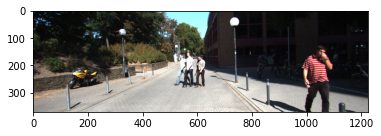

In [9]:
import glob
DATA_PATH = '/home/slabban/machine_learning_courses/datasets/think_autonomous/hydranets'
IMAGE_PATH = DATA_PATH + '/data/'
images_files = glob.glob(IMAGE_PATH + '*.png')
idx = np.random.randint(0, len(images_files))

img_path = images_files[idx]
img = np.array(Image.open(img_path))
plt.imshow(img)
plt.show()

image = Image.open(requests.get(url, stream=True).raw)

model.to(device)

segm = pipeline(img)

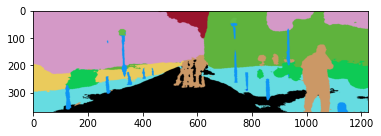

In [10]:
plt.imshow(segm)

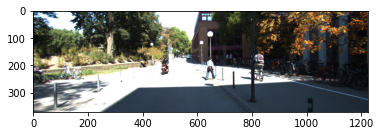

In [11]:
import glob
DATA_PATH = '/home/slabban/machine_learning_courses/datasets/think_autonomous/hydranets'
IMAGE_PATH = DATA_PATH + '/data/'
images_files = glob.glob(IMAGE_PATH + '*.png')
idx = np.random.randint(0, len(images_files))

img_path = images_files[idx]
img = np.array(Image.open(img_path))
plt.imshow(img)
plt.show()

In [18]:
video_files = sorted(glob.glob(IMAGE_PATH + '*.png'))
VIDEO_OUT_PATH = DATA_PATH + '/output/out.mp4'

# Set the Model to Eval on GPU
if torch.cuda.is_available():
    _ = model.cuda()
_ = model.eval()

# Load the Weights
# ckpt = torch.load('ExpKITTI_joint.ckpt')
# hydranet.load_state_dict(ckpt['state_dict'])

# Run the pipeline
result_video = []
for idx, img_path in enumerate(video_files):
    image = np.array(Image.open(img_path))
    h, w, _ = image.shape 
    seg = pipeline(image)
    result_video.append(cv2.cvtColor(cv2.vconcat([image, seg]), cv2.COLOR_BGR2RGB))

out = cv2.VideoWriter(VIDEO_OUT_PATH,cv2.VideoWriter_fourcc(*'mp4v'), 15, (w,2*h))

for i in range(len(result_video)):
    out.write(result_video[i])
out.release()

In [15]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open(VIDEO_OUT_PATH,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=800 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)